# Play w w/o embeddings

In [18]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=2

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace
from pytorch.encoder_decoder import (make_model,
                                     SimpleLossCompute)

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

env: CUDA_VISIBLE_DEVICES=2
CUDA: True
cuda:0


In [ ]:
run_epoch

In [3]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

In [7]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

In [8]:
def train_copy_task(emb_size):
    """Train the simple copy task."""
    num_words = 11
    # criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    criterion = nn.NLLLoss(size_average=False, ignore_index=0)
    model = make_model(num_words,
                       num_words,
                       device=DEVICE,
                       emb_size=emb_size,
                       hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))
 
    dev_perplexities = []
    
    if USE_CUDA:
        model.cuda()

    for epoch in range(10):
        
        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad(): 
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)
        
    return dev_perplexities

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 20.044893 Tokens per Sec: 11938.392983
Epoch Step: 100 Loss: 17.905952 Tokens per Sec: 11944.160682
Evaluation perplexity: 7.241447

Example #1
Src :  9 9 1 6 10 9 2 2 3
Trg :  9 9 1 6 10 9 2 2 3
Pred:  9 9 9 9 9 9 9 9 9

Example #2
Src :  5 6 6 3 6 6 8 2 3
Trg :  5 6 6 3 6 6 8 2 3
Pred:  6 6 6 6 6 6 6 6 6

Epoch 1
Epoch Step: 50 Loss: 16.122639 Tokens per Sec: 12901.691289
Epoch Step: 100 Loss: 12.517569 Tokens per Sec: 13032.871902
Evaluation perplexity: 3.824094

Example #1
Src :  9 9 1 6 10 9 2 2 3
Trg :  9 9 1 6 10 9 2 2 3
Pred:  9 9 10 2 6 9 2 2 9

Example #2
Src :  5 6 6 3 6 6 8 2 3
Trg :  5 6 6 3 6 6 8 2 3
Pred:  6 6 5 6 3 8 6 3 6

Epoch 2
Epoch Step: 50 Loss: 8.160336 Tokens per Sec: 12866.917026
Epoch Step: 100 Loss: 4.422697 Tokens per Sec: 12832.043450
Evaluation perplexity: 1.618500

Example #1
Src :  9 9 1 6 10 9 2 2 3
Trg :  9 9 1 6 10 9 2 2 3
Pred:  9 9 6 1 9 10 2 2 3

Example #2
Src :  5 6 6 3 6 6 8 2 3
Trg :  5 6 6 3 6 6 8 2 3
Pred:  6 5 6

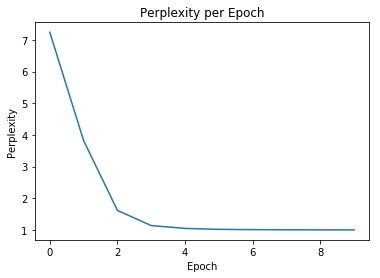

In [9]:
# train the copy task
# try embedding size = 1
dev_perplexities = train_copy_task(emb_size=32)

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 20.620859 Tokens per Sec: 13144.345327
Epoch Step: 100 Loss: 20.235697 Tokens per Sec: 13655.166913
Evaluation perplexity: 9.289641

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  10 10 10 10 10 10 10 10 10

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  6 6 6 6 6 6 6 6 6

Epoch 1
Epoch Step: 50 Loss: 19.976292 Tokens per Sec: 13774.029839
Epoch Step: 100 Loss: 19.776014 Tokens per Sec: 12919.903457
Evaluation perplexity: 8.729949

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  3 3 3 9 9 9 9 9 9

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  3 3 4 6 6 6 6 6 6

Epoch 2
Epoch Step: 50 Loss: 19.390150 Tokens per Sec: 12943.363090
Epoch Step: 100 Loss: 18.283533 Tokens per Sec: 12725.037413
Evaluation perplexity: 7.795435

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  8 2 2 2 10 10 10 5 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2


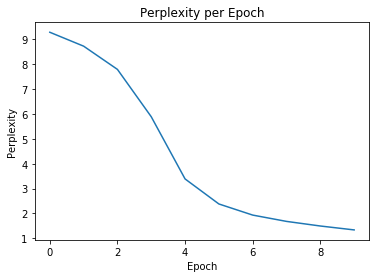

In [8]:
# train the copy task
# try embedding size = 1
dev_perplexities = train_copy_task(emb_size=1)

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 19.715988 Tokens per Sec: 15243.757510
Epoch Step: 100 Loss: 17.732924 Tokens per Sec: 14671.975055
Evaluation perplexity: 7.076631

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  7 7 5 7 5 7 5 7 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  6 6 6 8 6 6 6 3 6

Epoch 1
Epoch Step: 50 Loss: 15.542068 Tokens per Sec: 16073.500298
Epoch Step: 100 Loss: 11.795482 Tokens per Sec: 14953.629224
Evaluation perplexity: 3.499979

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 7 8 7 8 3 8 7

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 6 2 8 6 8 2 6

Epoch 2
Epoch Step: 50 Loss: 7.732324 Tokens per Sec: 15271.867974
Epoch Step: 100 Loss: 5.230344 Tokens per Sec: 17670.540350
Evaluation perplexity: 1.730301

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 10 8 7 3 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 

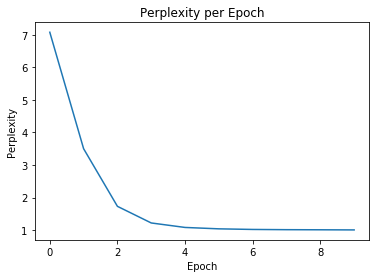

In [19]:
# train the copy task
dev_perplexities = train_copy_task()

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

# Mimic the dataset structure

In [22]:
!pip install git+git://github.com/pytorch/text spacy 

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-zuwqmp5n
    100% |################################| 23.3MB 696kB/s eta 0:00:01  0% |                                | 215kB 2.7MB/s eta 0:00:09
    100% |################################| 153kB 27.7MB/s ta 0:00:01
    100% |################################| 92kB 23.2MB/s ta 0:00:01
    100% |################################| 614kB 21.6MB/s ta 0:00:01
    100% |################################| 194kB 20.7MB/s ta 0:00:01
    100% |################################| 1.9MB 12.6MB/s ta 0:00:01
    100% |################################| 317kB 18.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for torchtext ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pplwnwc5/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /home/keras/.cache/pip/wheels/e2/5d/17/f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
  Running setup.py bdist_wheel f

In [23]:
!python -m spacy download en
!python -m spacy download de

    100% |################################| 37.4MB 10.0MB/s a 0:00:0111 3% |#                               | 1.2MB 51.1MB/s eta 0:00:01
  Running setup.py install for en-core-web-sm ... done
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |################################| 38.2MB 96.9MB/s eta 0:00:01 1% |                                | 450kB 840kB/s eta 0:00:45    13% |####                            | 5.3MB 27.8MB/s eta 0:00:02    63% |####################            | 24.2MB 62.5MB/s eta 0:00:01    82% |##########################      | 31.3MB 83.3MB/s eta 0:00:01
  Running setup.py install for de-core-news-sm ... done
You are using pip version 10.0.1, however version 18.1 is availabl

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def score_task1(df_true, df_pred):
    df_true = df_true.set_index('id')
    df_pred = df_pred.set_index('id')
    df_pred = df_pred.loc[df_true.index]
    return f1_score(df_true.target, df_pred.target, average='macro')


def score_task2(df_true, df_pred):
    df_true = df_true.set_index('id')
    df_pred = df_pred.set_index('id')
    df_pred = df_pred.loc[df_true.index]

    # false correction if no target == 1
    df_pred.loc[df_pred.target != 1] = ''
    return np.mean(df_true.loc[df_true.target == 1, 'fullname_true']
                   == df_pred.loc[df_true.target == 1, 'fullname_true'])

In [9]:
import re
import pandas as pd
from torchtext import data, datasets

"""
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

cns = train_df.country.value_counts()
top_countries = list(cns[cns>100].index)
        
train_df['country'] = train_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')
train_df.loc[pd.isnull(train_df.fullname_true),
             'fullname_true'] = train_df.loc[pd.isnull(train_df.fullname_true),
                                             'fullname']

test_df['country'] = test_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')

cn_dict = dict(zip(sorted(list(train_df['country'].unique())),
                   range(train_df['country'].nunique())))

train_df['country'] = train_df['country'].apply(lambda x: cn_dict[x])
test_df['country'] = test_df['country'].apply(lambda x: cn_dict[x])
# fake full name for consistency with boilerplate NMT code
test_df['fullname_true'] = test_df['fullname']
test_df['target'] = 0

cols = ['id','fullname','fullname_true','target','country']
train_df = train_df[cols].set_index('id')
test_df = test_df[cols].set_index('id')

train_df.to_csv('../data/proc_train.csv')
test_df.to_csv('../data/proc_test.csv')
"""

def cleaner(text):
    new_text = text
    new_text = re.sub("[_\n/]", " ", new_text)
    new_text = re.sub("[12345?[|]", "", new_text)
    new_text = re.sub("Є", "Е", new_text)
    return new_text

def tokenize(text):
    return list(cleaner(text))

UNK_TOKEN = "!"
PAD_TOKEN = "_"    
SOS_TOKEN = "["
EOS_TOKEN = "]"
LOWER = False

ID = data.Field(sequential=False,
                use_vocab=False)

NAMES = data.Field(tokenize=tokenize, 
                 batch_first=True,
                 lower=LOWER,
                 include_lengths=True,
                 unk_token=UNK_TOKEN,
                 pad_token=PAD_TOKEN,
                 init_token=None,
                 eos_token=EOS_TOKEN)

TRG_NAMES = data.Field(tokenize=tokenize, 
                       batch_first=True,
                       lower=LOWER,
                       include_lengths=True,
                       unk_token=UNK_TOKEN,
                       pad_token=PAD_TOKEN,
                       init_token=SOS_TOKEN,
                       eos_token=EOS_TOKEN)

LBL = data.Field(sequential=False,
                 use_vocab=False)

CNT = data.Field(sequential=False,
                 use_vocab=False)

datafields = [("id", ID),
              ("src", NAMES),
              ("trg", TRG_NAMES),
              ("clf", LBL),
              ("cn", CNT)
             ]

train_data = data.TabularDataset(path="../data/proc_train.csv",
                                 format='csv',
                                 skip_header=True,
                                 fields=datafields)

train_data, valid_data = train_data.split(split_ratio=0.9,
                                          stratified=True,
                                          strata_field='cn')

In [10]:
MIN_FREQ = 1  # NOTE: we limit the vocabulary to frequent words for speed
NAMES.build_vocab(train_data.src, min_freq=MIN_FREQ)
TRG_NAMES.build_vocab(train_data.trg, min_freq=MIN_FREQ)
PAD_INDEX = TRG_NAMES.vocab.stoi[PAD_TOKEN]

In [10]:
def print_data_info(train_data, valid_data, src_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    # print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    # print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common letters:")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 letters (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    
    print("Number of letters:", len(src_field.vocab))
    

In [11]:
print_data_info(train_data, valid_data, NAMES)

Data set sizes (number of sentence pairs):
train 1592882
valid 398222
First training example:
src: К А Р И М О В А   Ч А М А Н Г У Л   М А Т Н А З А Р О В Н А
Most common letters:
         А    5071360
         О    3138102
         И    2930829
              2925170
         В    2731778
         Н    2320880
         Р    1940045
         Е    1835899
         Л    1635395
         М    1419430 

First 10 letters (src):
00 !
01 _
02 ]
03 А
04 О
05 И
06  
07 В
08 Н
09 Р 

Number of letters: 76


In [73]:
torch.max(torch.randn((2,2,)),dim=1)

(tensor([ 0.4557, -0.2327]), tensor([ 0,  1]))

In [94]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)

def greedy_decode_batch(model,
                        src, src_mask, src_lengths,
                        max_len=100,
                        sos_index=1, eos_index=None):
    """Greedily decode a sentence."""
    batch_size = src.size(0)
    
    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(batch_size, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    # attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data
        output.append(next_word.cpu().numpy())
        prev_y = next_word.unsqueeze(dim=1)
        # attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    # if eos_index is not None:
    #    first_eos = np.where(output==eos_index)[0]
    #    if len(first_eos) > 0:
    #        output = output[:first_eos[0]]      
    
    output = np.stack(output).T
    
    return output #, np.concatenate(attention_scores, axis=1)

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [280]:
for batch in valid_iter_batch:
    batch = rebatch(PAD_INDEX,batch=batch)
    break

In [76]:
batch.src.shape

torch.Size([512, 11])

In [77]:
src_eos_index = NAMES.vocab.stoi[EOS_TOKEN]
trg_sos_index = TRG_NAMES.vocab.stoi[SOS_TOKEN]
trg_eos_index = TRG_NAMES.vocab.stoi[EOS_TOKEN]

In [95]:
result = greedy_decode_batch(
  model, batch.src, batch.src_mask, batch.src_lengths,
  max_len=100, sos_index=trg_sos_index, eos_index=trg_eos_index)

In [96]:
result

array([[48, 28, 31, ...,  1,  1,  1],
       [ 9, 11, 22, ...,  1,  1,  1],
       [12, 29, 21, ...,  1,  1,  1],
       ...,
       [35,  6, 35, ...,  1,  1,  1],
       [10,  6, 10, ...,  1,  1,  1],
       [26,  6, 54, ...,  1,  1,  1]])

In [90]:
len(result)

100

In [104]:
result[0].shape

(100,)

In [103]:
src.shape

(11,)

In [153]:
idx = np.random.randint(0,batch.src.size(0))
src = batch.src.cpu().numpy()[idx, :]
trg = batch.trg_y.cpu().numpy()[idx, :]
res = result[idx]        
print("Src : ", "".join(lookup_words(src, vocab=NAMES.vocab)))
print("Trg : ", "".join(lookup_words(trg, vocab=TRG_NAMES.vocab)))
print("Pred: ", "".join(lookup_words(res, vocab=TRG_NAMES.vocab)))

Src :  Й ЦУ]______
Trg :  Й ЦУ]_______
Pred:  Й ЦУ]_______________________________________________________________________________________________


In [46]:
batch


[torchtext.data.batch.Batch of size 1]
	[.id]:[torch.cuda.LongTensor of size 1 (GPU 0)]
	[.src]:('[torch.cuda.LongTensor of size 1x33 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.trg]:('[torch.cuda.LongTensor of size 1x34 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.clf]:[torch.cuda.LongTensor of size 1 (GPU 0)]
	[.cn]:[torch.cuda.LongTensor of size 1 (GPU 0)]

In [282]:
batch.src.shape,batch.src_mask.shape,batch.src_lengths.shape

(torch.Size([512, 11]), torch.Size([512, 1, 11]), torch.Size([512]))

In [295]:
classifier = nn.Sequential((nn.Linear((1+int(1)) * 256, 300)),
                              nn.Dropout(p=0.1),
                              nn.LeakyReLU(),
                              nn.Linear(300, 128),
                              nn.Dropout(p=0.1),
                              nn.LeakyReLU(),
                              nn.Linear(128, 3))

In [296]:
classifier(encoder_hidden.cpu()).mean(dim=1).shape

torch.Size([512, 3])

In [283]:
encoder_hidden, encoder_final = model.encode(batch.src,
                                              batch.src_mask,
                                              batch.src_lengths)

In [284]:
encoder_hidden.shape,encoder_final.shape

(torch.Size([512, 11, 512]), torch.Size([1, 512, 512]))

In [216]:
def run_epoch(data_iter,
              model,
              loss_compute,
              print_every=50,
              num_batches=100):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    with tqdm(total=num_batches) as pbar:
        for i, batch in enumerate(data_iter, 1):

            out, _, pre_output = model.forward(batch.src, batch.trg,
                                               batch.src_mask, batch.trg_mask,
                                               batch.src_lengths, batch.trg_lengths)
            loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
            total_loss += loss
            total_tokens += batch.ntokens
            print_tokens += batch.ntokens

            if model.training and i % print_every == 0:
                elapsed = time.time() - start
                print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                        (i, loss / batch.nseqs, print_tokens / elapsed))
                start = time.time()
                print_tokens = 0
            
            pbar.update(1)
                
    return math.exp(total_loss / float(total_tokens))

def train(model,
          num_epochs=10,
          lr=2*1e-4,
          print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    # criterion = nn.NLLLoss(reduce=, ignore_index=PAD_INDEX)
    criterion = nn.NLLLoss(size_average=False, ignore_index=0)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []
    dev_preds = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        print('Training the model')
        model.train()
        """
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every,
                                     num_batches=len(train_iter))
        """
        model.eval()
        with torch.no_grad():
            print('Evaluating the model')
            """
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=10, src_vocab=NAMES.vocab, trg_vocab=TRG_NAMES.vocab)        
            """
            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter_batch), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None),
                                       num_batches=len(valid_iter_batch))
            

            preds = predict((rebatch(PAD_INDEX, x) for x in valid_iter_batch), 
                            model, max_len=70, src_vocab=NAMES.vocab, trg_vocab=TRG_NAMES.vocab,
                            num_batches=len(valid_iter_batch)) 
            
            dev_preds.extend(preds)
            
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities,dev_preds

def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break
            
def predict(example_iter, model, max_len=100, 
            sos_index=1, 
            src_eos_index=None, 
            trg_eos_index=None, 
            src_vocab=None, trg_vocab=None,
            num_batches=100):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None

    preds = []

    with tqdm(total=num_batches) as pbar:
        for i, batch in enumerate(example_iter):

            output = greedy_decode_batch(
              model, batch.src, batch.src_mask, batch.src_lengths,
              max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)

            # cut off everything starting from </s> 
            # (only when eos_index provided)
            if trg_eos_index is not None:
                # iterate over sentence predictions and cut off from eos
                for pred in output:
                    first_eos = np.where(pred==trg_eos_index)[0]
                    if len(first_eos) > 0:
                        # produce sentences
                        preds.append("".join(lookup_words(pred[:first_eos[0]],
                                             vocab=TRG_NAMES.vocab)))
            pbar.update(1)
    return preds

In [44]:
train_iter = data.BucketIterator(train_data,
                                 batch_size=512,
                                 train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)),
                                 repeat=False,
                                 device=DEVICE,
                                 shuffle=True)

valid_iter = data.Iterator(valid_data,
                           batch_size=1,
                           train=False,
                           sort=False,
                           repeat=False, 
                           device=DEVICE)

valid_iter_batch = data.Iterator(valid_data,
                           batch_size=512,
                           train=False,
                           sort_within_batch=True,
                           sort_key=lambda x: (len(x.src), len(x.trg)),
                           repeat=False, 
                           device=DEVICE,
                           shuffle=False)

def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [39]:
val_ids = []
for b in valid_iter:
    val_ids.extend(list(b.id.cpu().numpy()))

In [163]:
val_ids

[1763541,
 361081,
 1361399,
 175491,
 586990,
 629776,
 1448272,
 1177837,
 14087,
 436394,
 1058886,
 634640,
 1170735,
 1238753,
 1264272,
 234061,
 1367493,
 1291992,
 1208654,
 1422147,
 1980736,
 221351,
 1328396,
 564979,
 205771,
 1895036,
 704375,
 1478253,
 1799704,
 1253527,
 1127169,
 1632428,
 1896440,
 1880670,
 801157,
 796851,
 1797501,
 1478725,
 1102253,
 952937,
 912277,
 1201027,
 979721,
 775371,
 755955,
 1439509,
 100407,
 88135,
 1805274,
 1519072,
 1679208,
 361042,
 104203,
 184267,
 369433,
 1713690,
 1792137,
 1017153,
 1311293,
 534,
 768462,
 407381,
 417441,
 68729,
 324638,
 64400,
 1468633,
 1245941,
 1920579,
 544855,
 589843,
 220441,
 296686,
 196222,
 1247550,
 1326348,
 1583410,
 1074569,
 796533,
 1688353,
 1046654,
 1552859,
 409163,
 675628,
 1406371,
 1640126,
 624860,
 1077734,
 1966146,
 567139,
 56144,
 364612,
 1356885,
 84280,
 357177,
 961406,
 1153893,
 1192598,
 1450489,
 1875393,
 1107958,
 1389221,
 495972,
 1272779,
 1849306,
 102273

In [13]:
model = make_model(len(NAMES.vocab),
                   len(TRG_NAMES.vocab),
                   device=DEVICE,
                   emb_size=32,
                   hidden_size=256,
                   num_layers=1,
                   dropout=0.2)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [14]:
model

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(32, 256, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(544, 256, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2)
    (pre_output_layer): Linear(in_features=800, out_features=256, bias=False)
  )
  (src_embed): Embedding(76, 32)
  (trg_embed): Embedding(77, 32)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=77, bias=False)
  )
)

In [164]:
train_df = pd.read_csv('../data/proc_train.csv')

In [167]:
train_df = train_df.set_index('id')

In [271]:
val_gts = train_df.loc[val_ids,'fullname_true'].values
val_ors = train_df.loc[val_ids,'fullname'].values

In [217]:
dev_perplexities,dev_preds = train(model,
                                   num_epochs=1,
                                   print_every=500)

  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 0
Training the model
Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

100%|██████████| 389/389 [00:47<00:00,  5.52it/s]

Validation perplexity: 1.063839


In [218]:
len(dev_preds),len(val_gts)

(199107, 199110)

In [225]:
incorrect_idx = list(train_df[train_df.target==1].index.values)

In [232]:
val_ids

[1763541,
 361081,
 1361399,
 175491,
 586990,
 629776,
 1448272,
 1177837,
 14087,
 436394,
 1058886,
 634640,
 1170735,
 1238753,
 1264272,
 234061,
 1367493,
 1291992,
 1208654,
 1422147,
 1980736,
 221351,
 1328396,
 564979,
 205771,
 1895036,
 704375,
 1478253,
 1799704,
 1253527,
 1127169,
 1632428,
 1896440,
 1880670,
 801157,
 796851,
 1797501,
 1478725,
 1102253,
 952937,
 912277,
 1201027,
 979721,
 775371,
 755955,
 1439509,
 100407,
 88135,
 1805274,
 1519072,
 1679208,
 361042,
 104203,
 184267,
 369433,
 1713690,
 1792137,
 1017153,
 1311293,
 534,
 768462,
 407381,
 417441,
 68729,
 324638,
 64400,
 1468633,
 1245941,
 1920579,
 544855,
 589843,
 220441,
 296686,
 196222,
 1247550,
 1326348,
 1583410,
 1074569,
 796533,
 1688353,
 1046654,
 1552859,
 409163,
 675628,
 1406371,
 1640126,
 624860,
 1077734,
 1966146,
 567139,
 56144,
 364612,
 1356885,
 84280,
 357177,
 961406,
 1153893,
 1192598,
 1450489,
 1875393,
 1107958,
 1389221,
 495972,
 1272779,
 1849306,
 102273

In [234]:
len(incorrect_idx)

1013371

In [239]:
s = list(set(val_ids).intersection(set(incorrect_idx)))

122841

786432

In [276]:
for i in range(0,10):
    idx = val_ids.index(s[np.random.randint(0,len(s))])
    print(val_ors[idx])
    print(val_gts[idx])
    print(dev_preds[idx])
    print('\n')

ЮСУПЛВА ЗЯУРЕШ КУМАРОВНА
ЮСУПОВА ЗЯУРЕШ КУМАРОВНА
ЮСУПЛАВ ЗЯУРЕШ КУМАРОВНА


КАРАЛАШ ЕКАТЕРИНА ЧВАСИЛЬЕВНА
КАРАЛАШ ЕКАТЕРИНА ВАСИЛЬЕВНА
КАРАЛАШ ЕКАТЕРИНА ВАСИЛЬЕВНА


МАЛЕНКО ТАЬТЯНА МИХАЙЛОВНА
МАЛЕНКО ТАТЬЯНА МИХАЙЛОВНА
МАЛЕНКО ТАТЬЯНА МИХАЙЛОВНА


ХУСЕЙНОВКА МАРХАМАТ АДХАМОВА
ХУСЕЙНОВА МАРХАМАТ АДХАМОВА
ХУСЕЙНОВА МАРХАМАТ АДХАМОВА


БАХТОВАРИ АБУХАМИД
БАХТОВАРИ АБДУХАМИД
БАХТОВАРИ АБУХАМИД


САТТОРОВ КОДЫР МУХТГОРОВИЧ
САТТОРОВ КОДЫР МУХТОРОВИЧ
САТТОРОВ КОДЫР МУХТОРОВИЧ


ОМЕЛЬЧУК НАЛДЕЖДА
ОМЕЛЬЧУК НАДЕЖДА
ОМЕЛЬЧУК НАЛДЕЖДА


ШАПОВАЛОВА ЕВГЕНИЯ ВМКТОРОВНА
ШАПОВАЛОВА ЕВГЕНИЯ ВИКТОРОВНА
ШАПОВАЛОВА ЕВГЕНИЯ ВАКТОРОВНА


РУСТАМОЫ ЭЛЁР ФОЗИЛОВИЧ
РУСТАМОВ ЭЛЁР ФОЗИЛОВИЧ
РУСТАМОВ ЭЛЁР ФОЗИЛОВИЧ


КРИУЛИН АЛЕКСАНЛР
КРИУЛИН АЛЕКСАНДР
КРИУЛИН АЛЕКСАНЛР




'BOICU OLGA'

'BOICU OLGA'

In [ ]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

# Collect all together

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=2
import os 
import math
import copy
import time

import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torchtext import data, datasets

import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from pytorch.encoder_decoder import make_model

from pytorch.encoder_decoder_utils import (Batch,rebatch,
                                           SimpleLossCompute,
                                           cleaner,
                                           tokenize,
                                           greedy_decode_batch,
                                           lookup_words,
                                           run_epoch
                                           )

from pytorch.metrics import (score_task1,
                             score_task2)

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ["USE_CUDA"] = str(USE_CUDA)

env: CUDA_VISIBLE_DEVICES=2
CUDA: True
cuda:0


In [2]:
"""
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

cns = train_df.country.value_counts()
top_countries = list(cns[cns>100].index)
        
train_df['country'] = train_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')
train_df.loc[pd.isnull(train_df.fullname_true),
             'fullname_true'] = train_df.loc[pd.isnull(train_df.fullname_true),
                                             'fullname']

test_df['country'] = test_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')

cn_dict = dict(zip(sorted(list(train_df['country'].unique())),
                   range(train_df['country'].nunique())))

train_df['country'] = train_df['country'].apply(lambda x: cn_dict[x])
test_df['country'] = test_df['country'].apply(lambda x: cn_dict[x])
# fake full name for consistency with boilerplate NMT code
test_df['fullname_true'] = test_df['fullname']
test_df['target'] = 0

cols = ['id','fullname','fullname_true','target','country']
train_df = train_df[cols].set_index('id')
test_df = test_df[cols].set_index('id')

train_df.to_csv('../data/proc_train.csv')
test_df.to_csv('../data/proc_test.csv')
"""

UNK_TOKEN = "!"
PAD_TOKEN = "_"    
SOS_TOKEN = "["
EOS_TOKEN = "]"
LOWER = False

ID = data.Field(sequential=False,
                use_vocab=False)

NAMES = data.Field(tokenize=tokenize, 
                 batch_first=True,
                 lower=LOWER,
                 include_lengths=True,
                 unk_token=UNK_TOKEN,
                 pad_token=PAD_TOKEN,
                 init_token=None,
                 eos_token=EOS_TOKEN)

TRG_NAMES = data.Field(tokenize=tokenize, 
                       batch_first=True,
                       lower=LOWER,
                       include_lengths=True,
                       unk_token=UNK_TOKEN,
                       pad_token=PAD_TOKEN,
                       init_token=SOS_TOKEN,
                       eos_token=EOS_TOKEN)

LBL = data.Field(sequential=False,
                 use_vocab=False)

CNT = data.Field(sequential=False,
                 use_vocab=False)

datafields = [("id", ID),
              ("src", NAMES),
              ("trg", TRG_NAMES),
              ("clf", LBL),
              ("cn", CNT)
             ]

train_data = data.TabularDataset(path="../data/proc_train.csv",
                                 format='csv',
                                 skip_header=True,
                                 fields=datafields)

train_data, valid_data = train_data.split(split_ratio=0.9,
                                          stratified=True,
                                          strata_field='cn')

In [3]:
print('Train length {}, val length {}'.format(len(train_data),len(valid_data)))

Train length 1791994, val length 199110


In [4]:
batch_size = 256

In [5]:
MIN_FREQ = 1  # NOTE: we limit the vocabulary to frequent words for speed
NAMES.build_vocab(train_data.src, min_freq=MIN_FREQ)
TRG_NAMES.build_vocab(train_data.trg, min_freq=MIN_FREQ)
PAD_INDEX = TRG_NAMES.vocab.stoi[PAD_TOKEN]

train_iter = data.BucketIterator(train_data,
                                 batch_size=batch_size,
                                 train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)),
                                 repeat=False,
                                 device=DEVICE,
                                 shuffle=True)

valid_iter_batch = data.Iterator(valid_data,
                           batch_size=batch_size,
                           train=False,
                           sort_within_batch=True,
                           sort_key=lambda x: (len(x.src), len(x.trg)),
                           repeat=False, 
                           device=DEVICE,
                           shuffle=False)

val_ids = []
for b in valid_iter_batch:
    val_ids.extend(list(b.id.cpu().numpy()))

In [6]:
train_df = pd.read_csv('../data/proc_train.csv')
train_df = train_df.set_index('id')
val_gts = train_df.loc[val_ids,'fullname_true'].values
val_ors = train_df.loc[val_ids,'fullname'].values
incorrect_idx = list(train_df[train_df.target==1].index.values)

incorrect_val_ids = list(set(val_ids).intersection(set(incorrect_idx)))
correct_val_ids = list(set(val_ids)-set(incorrect_val_ids))

print('Making dictionaries')
id2gt = dict(train_df['fullname_true'])
id2clf_gt = dict(train_df['target'])

val_gts = [id2gt[_] for _ in val_ids]
val_clf_gts = [id2clf_gt[_] for _ in val_ids]

Making dictionaries


In [7]:
def train(model,
          num_epochs=10,
          lr=3*1e-4,
          print_every=100,
          train_iter=train_iter,
          valid_iter_batch=valid_iter_batch):
    """Train a model on IWSLT"""
    
    # optionally add label smoothing; see the Annotated Transformer
    # criterion = nn.NLLLoss(reduce=, ignore_index=PAD_INDEX)
    criterion = nn.NLLLoss(size_average=False, ignore_index=0)
    clf_criterion = nn.CrossEntropyLoss()
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    # dev_perplexities = []
    # dev_preds = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        print('Training the model')
        model.train()
        
        
        train_perplexity, train_clf_loss = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                                     model,
                                                     SimpleLossCompute(model.generator,
                                                                       criterion,clf_criterion,
                                                                       optim),
                                                     print_every=print_every,
                                                     num_batches=len(train_iter),
                                                     epoch_no=epoch)
       
        model.eval()
        with torch.no_grad():
            print('Evaluating the model')
            """
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=10, src_vocab=NAMES.vocab, trg_vocab=TRG_NAMES.vocab)        
            """
            dev_perplexity, dev_clf_loss = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter_batch), 
                                                     model, 
                                                     SimpleLossCompute(model.generator,
                                                                       criterion, clf_criterion,
                                                                       None),
                                                     num_batches=len(valid_iter_batch),
                                                     epoch_no=epoch)
            

            preds,clf_preds = predict((rebatch(PAD_INDEX, x) for x in valid_iter_batch),
                                      model, max_len=70, src_vocab=NAMES.vocab, trg_vocab=TRG_NAMES.vocab,
                                      num_batches=len(valid_iter_batch)) 
            
            df_true = pd.DataFrame(
                {'id': val_ids,
                 'target': val_clf_gts,
                 'fullname_true':val_gts
                })
            df_pred = pd.DataFrame(
                {'id': val_ids,
                 'target': clf_preds,
                 'fullname_true':preds
                })

            score1 = score_task1(df_true, df_pred)
            score2 = score_task2(df_true, df_pred)
            
            # dev_preds.extend(preds)
            print("Validation CLF Loss: %f" % dev_clf_loss)
            print("Validation perplexity: %f" % dev_perplexity)
            print("Score 1 {} / Score 2 {}".format(score1,score2))
            # dev_perplexities.append(dev_perplexity)
        
    return dev_perplexity,dev_clf_loss,preds,clf_preds 

def predict(example_iter, model, max_len=100, 
            sos_index=1, 
            src_eos_index=None, 
            trg_eos_index=None, 
            src_vocab=None, trg_vocab=None,
            num_batches=100):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None

    preds = []
    clf_preds = []

    with tqdm(total=num_batches) as pbar:
        for i, batch in enumerate(example_iter):

            output, pred_classes = greedy_decode_batch(
                model, batch.src, batch.src_mask, batch.src_lengths,
                max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)

            clf_preds.extend(list(pred_classes))
            
            # cut off everything starting from </s> 
            # (only when eos_index provided)
            if trg_eos_index is not None:
                # iterate over sentence predictions and cut off from eos
                for pred in output:
                    first_eos = np.where(pred==trg_eos_index)[0]
                    if len(first_eos) > 0:
                        # produce sentences
                        preds.append("".join(lookup_words(pred[:first_eos[0]],
                                             vocab=TRG_NAMES.vocab)))
                    else:
                        preds.append("".join(lookup_words(pred[:],
                                             vocab=TRG_NAMES.vocab)))                        
            pbar.update(1)
    return preds,clf_preds

In [13]:
dev_perplexity,dev_clf_loss,(preds,clf_preds) = train(model,
                                                      num_epochs=1,
                                                      print_every=10,
                                                      train_iter=train_iter,
                                                      valid_iter_batch=valid_iter_batch)

  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch 0
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

100%|██████████| 389/389 [00:48<00:00,  5.09it/s]

Validation CLF Loss: 0.043791
Validation perplexity: 7.664554


In [29]:
dev_perplexity,dev_clf_loss,preds,clf_preds = train(model,
                                                    lr=3*1e-4,
                                                    num_epochs=5,
                                                    print_every=10,
                                                    train_iter=train_iter,
                                                    valid_iter_batch=valid_iter_batch)

  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch 0
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CLF Loss: 0.001132
Validation perplexity: 1.058362
Score 1 0.7667157381329958 / Score 2 0.38132686849574265
Epoch 1
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CLF Loss: 0.000756
Validation perplexity: 1.043601
Score 1 0.8771369809476454 / Score 2 0.5331717123935666
Epoch 2
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CLF Loss: 0.000595
Validation perplexity: 1.038028
Score 1 0.9080623550321385 / Score 2 0.5886845632292652
Epoch 3
Training the model


EPOCH 3:   1%|          | 36/3500 [00:09<09:21,  6.17it/s, clf_loss=(0.3155379667878151, 0.386107861995697), loss=(1.1229129095872243, 1.2264965772628784), tkns_per_sec=8.43e+04]  


KeyboardInterrupt: 

In [30]:
model = make_model(len(NAMES.vocab),
                   len(TRG_NAMES.vocab),
                   device=DEVICE,
                   emb_size=300,
                   hidden_size=256,
                   num_layers=1,
                   dropout=0.2,
                   num_classes=3)

dev_perplexity,dev_clf_loss,preds,clf_preds = train(model,
                                                    lr=1*1e-3,
                                                    num_epochs=3,
                                                    print_every=10,
                                                    train_iter=train_iter,
                                                    valid_iter_batch=valid_iter_batch)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch 0
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CLF Loss: 0.000610
Validation perplexity: 1.042382
Score 1 0.9044932273002644 / Score 2 0.5750650425733207
Epoch 1
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CLF Loss: 0.000527
Validation perplexity: 1.039240
Score 1 0.9199550142959714 / Score 2 0.6021562598549354
Epoch 2
Training the model


  0%|          | 0/389 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/389 [00:00<?, ?it/s]

100%|██████████| 389/389 [00:51<00:00,  4.63it/s]


Validation CLF Loss: 0.000467
Validation perplexity: 1.031403
Score 1 0.9317467091415024 / Score 2 0.6700863292336803


In [8]:
model = make_model(len(NAMES.vocab),
                   len(TRG_NAMES.vocab),
                   device=DEVICE,
                   emb_size=512,
                   hidden_size=512,
                   num_layers=2,
                   dropout=0.2,
                   num_classes=3)

dev_perplexity,dev_clf_loss,preds,clf_preds = train(model,
                                                    lr=1*1e-3,
                                                    num_epochs=3,
                                                    print_every=10,
                                                    train_iter=train_iter,
                                                    valid_iter_batch=valid_iter_batch)

  0%|          | 0/7000 [00:00<?, ?it/s]

Epoch 0
Training the model


  0%|          | 0/778 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Validation CLF Loss: 0.001204
Validation perplexity: 1.038273
Score 1 0.9123998757031274 / Score 2 0.6456681234797398
Epoch 1
Training the model


  0%|          | 0/778 [00:00<?, ?it/s]

Evaluating the model


  0%|          | 0/778 [00:00<?, ?it/s]

 11%|█         | 83/778 [00:12<01:46,  6.53it/s]


KeyboardInterrupt: 

In [14]:
len(preds),len(clf_preds)

(199110, 199110)

In [15]:
len(val_ids)

199110

# Dataset pre-processing

In [1]:
import re
import pandas as pd
from torchtext import data, datasets

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

cns = train_df.country.value_counts()
top_countries = list(cns[cns>100].index)
        
train_df['country'] = train_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')
train_df.loc[pd.isnull(train_df.fullname_true),
             'fullname_true'] = train_df.loc[pd.isnull(train_df.fullname_true),
                                             'fullname']

test_df['country'] = test_df['country'].apply(lambda x: x if x in top_countries else 'OTHER')

cn_dict = dict(zip(sorted(list(train_df['country'].unique())),
                   range(train_df['country'].nunique())))

train_df['country'] = train_df['country'].apply(lambda x: cn_dict[x])
test_df['country'] = test_df['country'].apply(lambda x: cn_dict[x])
# fake full name for consistency with boilerplate NMT code
test_df['fullname_true'] = test_df['fullname']
test_df['target'] = 0

cols = ['id','fullname','fullname_true','target','country']
train_df = train_df[cols].set_index('id')
test_df = test_df[cols].set_index('id')

# train_df.to_csv('../data/proc_train.csv')
# test_df.to_csv('../data/proc_test.csv')


In [2]:
len(cn_dict)

55

In [1]:
import pandas as pd

In [4]:
train_df = pd.read_csv('../data/proc_train.csv')

In [2]:
test_df = pd.read_csv('../data/proc_test.csv')

In [ ]:
train_df.

In [5]:
train_df.head()

,id,fullname,fullname_true,target,country
0,0,AKHMEDOV YGURIY,AKHMEDOV YURIY,1,44
1,1,ФОЗИЛОВ РАМИЛЬ ГУЛЛОВИЧ,ФОЗИЛОВ РАМИЛЬ ГУЛОВИЧ,1,44
2,2,ГОИБОВ АХЛИДДИН ШАМСУДИНОВИЧ,ГОИБОВ АХЛИДДИН ШАМСУДИНОВИЧ,0,44
3,3,ХУСНЕУТДИНОВА МАРГАРИТА ФАХИМОВНА,ХУСНУТДИНОВА МАРГАРИТА ФАХИМОВНА,1,44
4,4,НОВОКШОНОВА ИННА ВЛАДИМИРОВНА,НОВОКШОНОВА ИННА ВЛАДИМИРОВНА,0,44


In [3]:
test_df.head()

,id,fullname,fullname_true,target,country
0,0,ХУДАШКУРОВА ГУЛЗХОДА БЕРДИЕВНА,ХУДАШКУРОВА ГУЛЗХОДА БЕРДИЕВНА,0,51
1,1,СВЕЖЕТЬФЛОГИСТОН АРСЕН,СВЕЖЕТЬФЛОГИСТОН АРСЕН,0,44
2,2,ГУЛОМОВА СОЖИДА САНАЕВНА,ГУЛОМОВА СОЖИДА САНАЕВНА,0,51
3,3,КАМПЫШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА,КАМПЫШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА,0,28
4,4,OROSUMEBTOV MIRLAN,OROSUMEBTOV MIRLAN,0,44


# Check the prediction

In [1]:
import pandas as pd
import numpy as np

def argmax(string):
    arr = np.asarray(string.replace('[','')
                     .replace(']','')
                     .strip()
                     .replace('  ',' ').replace('  ',' ').replace('  ',' ').split())
    return np.argmax(arr)

In [2]:
!ls -laht predictions/ | head

total 4.7G
drwxr-xr-x 13 keras users 4.0K Nov 11 18:42 ..
-rw-r--r--  1 root  root  248M Nov 11 18:00 aug2_pseudo5x_final2.csv
drwxr-xr-x  2 keras users 4.0K Nov 11 18:00 .
-rw-r--r--  1 root  root  247M Nov 11 18:00 train_aug_correct_only_final2.csv
-rw-r--r--  1 root  root  432M Nov 10 07:29 aug2_pseudo_06_final2.csv
-rw-r--r--  1 keras users  98M Nov 10 06:36 stack_v4.csv
-rw-r--r--  1 root  root  248M Nov  8 12:48 aug2_pseudo_06_final.csv
-rw-r--r--  1 root  root  244M Nov  8 11:49 heavy_dec_skip_final.csv
-rw-r--r--  1 root  root  248M Nov  7 06:06 aug2_pseudo_06.csv


In [3]:
test_df = pd.read_csv('../data/test.csv')
predict_df = pd.read_csv('predictions/train_aug_correct_only_final2.csv')
predict_df = predict_df.sort_values(by='id',ascending=True).reset_index(drop=True)
test_df = test_df.sort_values(by='id',ascending=True).reset_index(drop=True)
assert list(predict_df.id.values) == list(test_df.id.values)
predict_df['target'] = predict_df['target'].apply(lambda x: argmax(x))
predict_df['fullname'] = test_df['fullname']

In [4]:
# assume that target = 2 is predicted correctly
# use the seq2seq prediction as a stronger indicator for targets 0 and 1
cond_0 = (predict_df.fullname_true == predict_df.fullname) & (predict_df.target.isin([0,1]))
cond_1 = (predict_df.fullname_true != predict_df.fullname) & (predict_df.target.isin([0,1]))
predict_df.loc[cond_0,'target'] = 0
predict_df.loc[cond_1,'target'] = 1

In [6]:
predict_df.loc[predict_df.target!=1,'fullname_true'] = ''
del predict_df['fullname']
predict_df = predict_df.set_index('id')
predict_df.to_csv('predictions/av_submit_final.csv')

In [8]:
predict_df

,target,fullname_true
id,,
0,1,ХУДАШКУРОВА ГУЛЗОДА БЕРДИЕВНА
1,2,
2,0,
3,0,
4,1,OROSUMBETOV MIRLAN
5,2,
6,1,РЕШЕТНИКОВ АЛЕКСАНДР
7,1,КУРБАНОВА ШАКИРА БАХОДИРОВНА
8,1,АМОНЛИКОВ РУСТАМ ЭШОНОВИЧ


In [9]:
predict_df[(predict_df.fullname_true != predict_df.fullname)\
           & (predict_df.target==2)].sample(n=20)

,id,target,fullname_true,fullname
1773338,1773338,2,ГАЛОЯН АБДУМАНОНОВИЧ БЕЗАВАРИЙНОСТЬ,ГАОЛЯН АБДУМАНОНОВИЧ БЕЗАВАРИЙНОСТЬ
1815704,1815704,2,МАМЕДОВ МАЛИКМАМЕД РЗАХАН,МАМЕДО МАЛИКМАМЕД РЗАХАН
541918,541918,2,ЦРЕБНЯ ДРАГОМИР,ЦРНОБНЯ ДРАГОМИР
563592,563592,2,ОУФМС Р ОССИИ П О СО-АВ ПРИГОРОДНОМ Р-НЕ,ОУФМС Р ОССИИ П О РСО-АВ ПРИГОРОДНОМ Р-НЕ
1422502,1422502,2,ПОРАЙКО ДУМИТРИЦА,ПОРАЙКО ДУВМИТРИЦА
1969686,1969686,2,АКПАЕПРРОГЛ ПНОРГЛОШДО ПГОРОГЛОЛДОЛ,АКПАЕПНРОГЛ ПНОРГЛОШДО ПГОРОГЛОЛДОЛ
1576973,1576973,2,ЗАКУТОВ АСС САЙФУЛЛОЕВ,ЗАКУТОКАСС САЙФУЛЛОЕВ
1830829,1830829,2,КРЕЦУ ВЛАД,КРЕЦУ ЫЛАД
603386,603386,2,ШАРЛАТАНСКИЙ МАРТЕНИК RUSU,ШАРЛАТАНСКИЙ МАРТЕНЩИК RUSU
2349937,2349937,2,VARDANYAN FEVIN,VARDANYANH FDVIN


In [6]:
predict_df[predict_df.fullname_true != predict_df.fullname].target.value_counts()

1    1463831
2        640
Name: target, dtype: int64

In [7]:
predict_df.target.value_counts()

1    1463831
0    1242591
2      61217
Name: target, dtype: int64

In [9]:
(35102+31228)/1692642

0.039187258735160775

In [6]:
cond = predict_df.fullname_true != predict_df.fullname
predict_df[cond].target.value_counts()

1    1618214
2      31228
Name: target, dtype: int64

In [18]:
cond = (predict_df.target==1)
predict_df[cond].sample(n=20)

,target,fullname_true
id,,
1980044,1,КАНАЕВА УГИЛЖОН АБДУМАЛИКОВНА
172352,1,МЕЛЬНИКОВА ЕВГЕНИЯ ЕВГЕНЬЕВНА
1412760,1,ТУРДИЕВ РАМИЛЬ ШОДМУРОДОВИЧ
1002881,1,АРИПОВ АБДУЛБОСИТ АБДУРАСУЛЖОНОВИЧ
2002626,1,ПЕТРУНИНА ИРИНА СЕМЕНОВНА
2399433,1,SOTIVOLDIYEVA OZODA ZOKIRJANOVNA
525,1,ГУЛИНА ОЛЬГА ВИКТОРОВНА
1914582,1,НАИМОВ МИРЗОАЛИ МАЙРОВИЧ
1671044,1,СИНАТУЛИН РОДИЯР СЕРГЕЕВИЧ


In [12]:
cond = (predict_df.fullname_true != predict_df.fullname) & (predict_df.target==1)
predict_df[cond].sample(n=20)

,id,target,fullname_true,fullname
660373,660373,1,ДЖОЛДОШБАЕВ ДЖЫЛДЫЗ ОРУНАЛИЕВИЧ,ДДОЛДОШБАЕВ ДЖЫЛДЫЗ ОРУНАЛИЕВИЧ
2077082,2077082,1,КАДИРОВ ХАКИМБЕК ЭРДОНОВИЧ,КАДИРОВ ХАКИМБЕК ЭРДОНОВИТЧ
2427133,2427133,1,КУДРАТОВА МУСАЛАМ,КУДРАТОВА МЫСАЛАМ
371930,371930,1,БАЗАРБАЕВ ШУХРАТ,БАЗАРБАЕВ ШУХРНАТ
2349480,2349480,1,НАЗАРОВА ХУСНОРО САМИЕВНА,НАЗАРОВАХУСНОРО САМИЕВНА
2703051,2703051,1,KAMALKHANOV MUZAFFAR MAXMUD OGLI,KAMALKBHANOV MUZAFFAR MAXMUD OGLI
2105819,2105819,1,HASANOV ANAR,HASANOV AQNAR
2721383,2721383,1,СИДОРОВ ЕВГЕНИЙ ЮРЬЕВИЧ,СИДОРОВ ЕВГЕНИЙ ЮРЬЕВТИЧ
243832,243832,1,КОНОВАЛОВ ИГОРЬ ИВАНОВИЧ,ЕОНОВАЛОВ ИГОРЬ ИВАНОВИЧ
992750,992750,1,САРУХАНЯН ГЕВОРК ШАЛИКОЕВИЧ,САРУХАНЯН ГНЕВОРК ШАЛИКОЕВИЧ


In [4]:
test_df.head()

,id,fullname,country
0,0,ХУДАШКУРОВА ГУЛЗХОДА БЕРДИЕВНА,УЗБЕКИСТАН
1,1,СВЕЖЕТЬФЛОГИСТОН АРСЕН,РОССИЯ
2,2,ГУЛОМОВА СОЖИДА САНАЕВНА,УЗБЕКИСТАН
3,3,КАМПЫШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА,КАЗАХСТАН
4,4,OROSUMEBTOV MIRLAN,РОССИЯ


In [13]:
predict_df.target.value_counts()

1    1692642
0    1009353
2      65644
Name: target, dtype: int64

In [12]:
predict_df[predict_df.target==0]

,target,fullname_true
id,,
1,2,СВЕЖЕТЬФЛОГИСТОН АРСЕН
5,2,ГОТОВЕНЬКИЙ НЕЛИКВИДНИЙ СВОЛОЧЬ
38,2,ZHUSUPBEKOVA NUЫIA НЕТ
80,2,ВRРУЧЕНИЕ ЭВАКУИРОВАТЬСЯ РАЗВЛЕКАТЬСЯ
193,2,КРОССВОРД РАЗОЧАРОВАННОСТЬ ВОКАБУЛR
363,2,ГУЛАДЖАБОВ НЕМАТДЖОН НЕТ
408,2,ЗАБИВАТЬСЯ АТОЛЛОВСЙ ПЕРЕКОНОПАТИТЬ
431,2,RФВRФВФR RФВФRВФ ФRВФRВФ
460,2,МИРЗОНОРОВ ЗАФАРДЖОН НЕТ


In [3]:
predict_df[predict_df.fullname_true!=predict_df.fullname]

,id,target,fullname_true,fullname
0,0,1,ХУДАШКУРОВА ГУЛЗОДА БЕРДИЕВНА,ХУДАШКУРОВА ГУЛЗХОДА БЕРДИЕВНА
3,3,1,КАМПАШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА,КАМПЫШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА
4,4,1,OЫOSUMETTOV MIXAN,OROSUMEBTOV MIRLAN
5,5,2,ГОТОВЕНЬКИЙ НЕЛИКВИДНИЙ СВОЛОЧЬ,ГОТОВЕНЬКИЙ НЕЛИКВИДНЫЙ СВОЛОЧЬ
6,6,1,РЕШЕТНИКОВ АЛЕКСАНДР,РЕШЕТНИКОВ АЛАЕКСАНДР
7,7,1,КУРБАНОВА ШАКИРА БАХОДИРОВНА,КУРБАНОВА ШАКИРАБАХОДИРОВНА
8,8,1,АМОНЛИКОВ РУСТАМ ЭШОНОВИЧ,АМОНЛИКОВ РСУТАМ ЭШОНОВИЧ
9,9,1,ЗОРЯКОВ АЛЕКСАНДР КОНСТАНТИНОВИЧ,ЗЫРЯЕОВ АЛЕКСАНДР КОНСТАНТИНОВИЧ
10,10,1,БЕЙШЕНБЕК-КАФЗУ ПЕРИЗАН,БЕЙШЕНБЕК-КЫФЗЫ ПЕРИЗАН
11,11,1,МИРОНОВА РУЗАННА БАБАДУСТОВНА,МИРОНОВА РУЗАННА БАБПДУСТОВНА


In [50]:
predict_df.sample(n=10)

,id,target,fullname_true,fullname
1186299,1186299,1,АБДИЕВ ХАЛИКУЛ АБРУРАХМАНОВИЧ,АБДИВ ХАЛИКУЛ АБРУРАХМАНОВИЧ
2594162,2594162,1,БОБОЕКОВ АМОНБЕК,БОБОЕКОВ АМОНБЕК
1974206,1974206,0,МАСАЛОВА НАТАЛЬЯ ВИКТОРОВНА,МАСАЛОВА НАТАЛЬЯ ВИКТОРОВНА
1617660,1617660,0,ТОРОСЯН ДИАНА НИКОЛАЕВНА,ТОРОСЯН ДИАНА НИКОЛАЕВНА
1820009,1820009,1,НИКИТАЕВА ЕЛЕНА ИВАНОВНА,НИКИТАЕВА ЕЛЕНА ИВАЕНОВНА
737322,737322,0,МАХКАМБАЕВ САИДЖАН МАХКАМБАЕВИЧ,МАХКАМБАЕВ САИДЖАН МАХКАМБАЕВИЧ
945034,945034,1,ЖОВЛИЕВ ХАЙРУЛЛА НОРБОБОЕВИЧ,ЖОВЛИЕВ ХАЙРУЕЛЛА НОРБОБОЕВИЧ
1557808,1557808,1,KARIMOV MAKHMADALI,KARIMOV MAKHMADALI
1650347,1650347,1,КОШЕЧКИНА ПОЛИНА ОСИПОВНА,КОШЕЧКИНА ПОЛИНА ОСИПОВНЕ
858065,858065,1,ХАСАНОВА ШАРОФЖОН КУРБОНОВИЧ,ХАСАНОВА ШАРФЖОН КУРБОНОВИЧ


In [19]:
import torch

In [21]:
n = 5

In [22]:
# your tensor of 16 x 28 dimensions, 
# where each element has some index (0 to n)
inp = torch.LongTensor(16, 28) % n    
inp_ = torch.unsqueeze(inp, 2)


In [23]:
inp_.shape

torch.Size([16, 28, 1])

In [ ]:

one_hot = torch.FloatTensor(16, 28, n).zero_()
one_hot.scatter_(2, inp_, 1)

print(inp)
print(one_hot)

True